### __Loading data + synching them__

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from modules.utils import *
from modules.localization import *
from modules.ogm import *
from modules.sensors import *
from modules.texture_mapping import *

In [3]:
dataset_num = 20 # or 21
dataset_names = {
    "encoder": "Encoders",
    "lidar": "Hokuyo",
    "imu": "Imu",
    "rgbd": "Kinect",
}

data = load_data(dataset_num, dataset_names)
encoder = Encoder(data["encoder"])
lidar = Lidar(data["lidar"])
imu = Imu(data["imu"])
kinect = Kinect(data["rgbd"])

synchronize_sensors(encoder, imu, lidar, base_sensor_index=0)

### __Generate pose estimates using differential-drive motion model__

In [4]:
v_ts = encoder.counts_synced
w_ts = imu.gyro_synced
x_ts = poses_from_odometry(v_ts, w_ts)

### __Plot robot's trajectory using pose estimates__

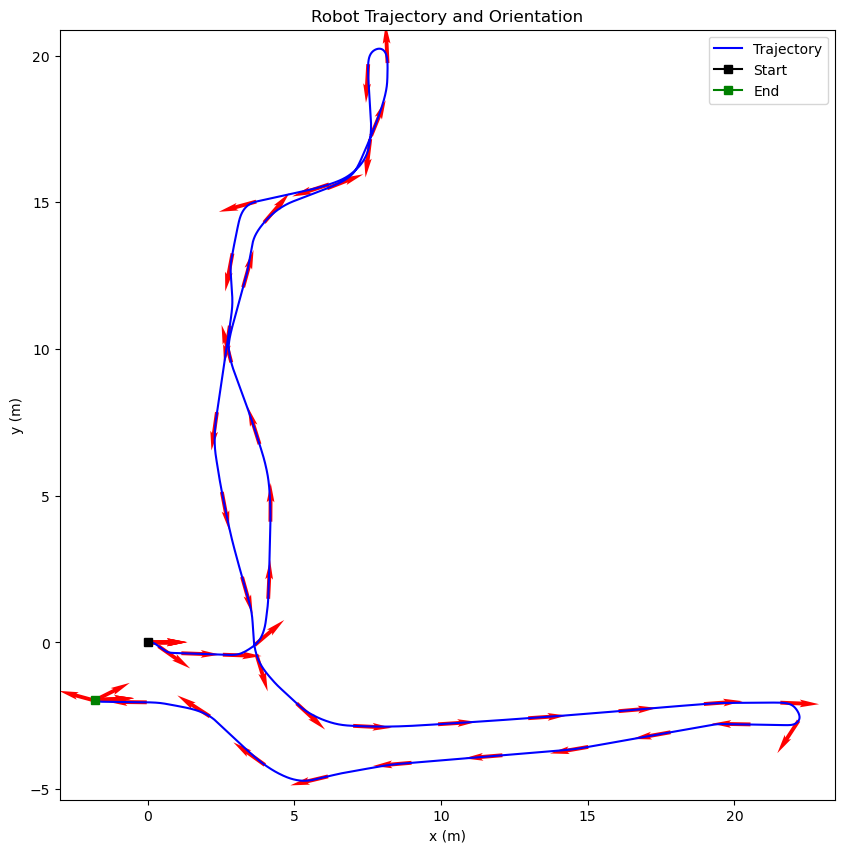

In [5]:
plot_trajectory(x_ts)

In [6]:
lidar_ranges, lidar_range_max, lidar_range_min = lidar.ranges_synced, lidar.range_max, lidar.range_min
z_ts = get_lidar_data(lidar_ranges, lidar_range_min, lidar_range_max)

### __Occupancy Grid Mapping with diff-drive pose estimates__

In [7]:
# res = 0.05
# ogm = OccupancyGridMap(res, 30., 30., -30., -30.)
# ogm.build_map(x_ts, z_ts)

In [8]:
# ogm.plot_log_odds_map()

In [9]:
# ogm.plot_map()

### __Generating Point Cloud from Depth and RGB images__

In [10]:
# Intrinsic matrix
K = np.array([
    [585.05,      0, 242.94],
    [     0, 585.05, 315.84],
    [     0,      0,      1]
])
M_int = np.hstack((K, np.zeros((3, 1))))

In [11]:
kinect.faster_camera_name()

'disp'

In [17]:
import random

non_floor_color = np.array([0, 0, 0])

max_index = kinect.rgb_stamps.shape[0] - 1
num_data_points = 1
random_rgb_img_num = [random.randint(0, max_index) for _ in range(num_data_points)]

for rgb_img_num in random_rgb_img_num:
    closest_stamps = kinect.get_closest_stamps(
        faster_sensor_stamps = kinect.disp_stamps,
        slower_sensor_stamps = kinect.rgb_stamps
    )
    disp_img_num = closest_stamps[rgb_img_num]

    disparity_PATH = "dataRGBD/Disparity" + str(dataset_num) + "/" + "disparity" + str(dataset_num) + "_" + str(disp_img_num) + ".png"
    rgb_PATH      = "dataRGBD/RGB" + str(dataset_num) + "/" + "rgb" + str(dataset_num) + "_" + str(rgb_img_num) + ".png"

    # Load the images
    disparity_image = read_image(disparity_PATH, is_disparity=True)
    depth_image = get_depth_image(disparity_image)
    rgb_image = read_image(rgb_PATH)

    # Generate point cloud
    pcl = vectorized_generate_point_cloud(depth_image, rgb_image, M_int)
    floor_points, non_floor_points = segment_floor_plane(pcl, return_non_floor_pcl=True)
    
    # Color the non-floor-points for debugging
    non_floor_points = color_point_cloud(non_floor_points, non_floor_color)
    
    # View the point cloud
    view_point_clouds([floor_points, non_floor_points])